In [ ]:
# Standard imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
# Local module imports
import sys
import os
sys.path.append(os.path.abspath('../'))

from src.preprocessing.cleaning import handle_missing_values, remove_duplicates, convert_to_datetime
from src.preprocessing.feature_engineering import extract_time_features, convert_ip_to_int, merge_ip_country
from src.preprocessing.transform import encode_categorical, scale_features, handle_imbalance
from src.preprocessing.utils import load_csv, save_csv


In [ ]:
# Load the dataset
credit_df = pd.read_csv("../data/raw/creditcard.csv")

# Check class distribution
print(credit_df['Class'].value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


In [ ]:
# Split features and target variable

Xc = credit_df.drop(columns=['Class'])  # Features
yc = credit_df['Class']                # Target

# Train-Test Split

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    Xc, yc, test_size=0.2, stratify=yc, random_state=42
)

# Handle Class Imbalance (SMOTE)

Xc_train_bal, yc_train_bal = handle_imbalance(Xc_train, yc_train)

# Scale Features
def scale_cr_features(X_train, X_test, method="standard"):
    if method == "standard":
        scaler = StandardScaler()
    elif method == "minmax":
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid method. Choose 'standard' or 'minmax'.")

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, scaler

Xc_train_scaled, Xc_test_scaled, scaler = scale_cr_features(Xc_train_bal, Xc_test)

# Convert to DataFrames again for easier exploration
Xc_train_scaled_df = pd.DataFrame(Xc_train_scaled, columns=Xc.columns)
Xc_test_scaled_df = pd.DataFrame(Xc_test_scaled, columns=Xc.columns)

# Final Check
print("Final training set shape:", Xc_train_scaled_df.shape)
print("Final test set shape:", Xc_test_scaled_df.shape)
print("Resampled class distribution:", pd.Series(yc_train_bal).value_counts())



Final training set shape: (454902, 30)
Final test set shape: (56962, 30)
Resampled class distribution: Class
0    227451
1    227451
Name: count, dtype: int64


In [ ]:
# Save the preprocessed data
import joblib

# For creditcard data
joblib.dump(Xc_train_scaled, 'Xc_train_scaled.pkl')
joblib.dump(Xc_test_scaled, 'Xc_test_scaled.pkl')
joblib.dump(yc_train_bal, 'yc_train_bal.pkl')
joblib.dump(yc_test, 'yc_test.pkl')


In [ ]:
# Load preprocessed data

import joblib
Xc_train_scaled = joblib.load('../data/processed/Xc_train_scaled.pkl')
Xc_test_scaled = joblib.load('../data/processed/Xc_test_scaled.pkl')
yc_train_bal = joblib.load('../data/processed/yc_train_bal.pkl')
yc_test = joblib.load('../data/processed/yc_test.pkl')

In [ ]:
# creditcard_model_training
import joblib
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report


#  Define models

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
}


#  Train & Evaluate

results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(Xc_train_scaled, yc_train_bal)
    y_pred = model.predict(Xc_test_scaled)
    y_prob = model.predict_proba(Xc_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(yc_test, y_pred)
    prec = precision_score(yc_test, y_pred)
    rec = recall_score(yc_test, y_pred)
    f1 = f1_score(yc_test, y_pred)
    roc_auc = roc_auc_score(yc_test, y_prob) if y_prob is not None else None

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "ROC-AUC": roc_auc
    })

    print(classification_report(yc_test, y_pred))


#  Show summary table

results_df = pd.DataFrame(results)
print("\n=== Model Comparison Results ===")
print(results_df)



Training Logistic Regression...
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.13      0.90      0.23        98

    accuracy                           0.99     56962
   macro avg       0.57      0.94      0.61     56962
weighted avg       1.00      0.99      0.99     56962


Training Random Forest...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.83      0.83        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962


Training Gradient Boosting...
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.18      0.90      0.31        98

    accuracy                           0.99     56962
   macro avg       0.59      0.95    

c:\Users\mike\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:13:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.86      0.83        98

    accuracy                           1.00     56962
   macro avg       0.90      0.93      0.92     56962
weighted avg       1.00      1.00      1.00     56962


=== Model Comparison Results ===
                 Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0  Logistic Regression  0.989853   0.134146  0.897959  0.233422  0.976482
1        Random Forest  0.999421   0.835052  0.826531  0.830769  0.964422
2    Gradient Boosting  0.992995   0.184486  0.897959  0.306087  0.979780
3              XGBoost  0.999403   0.807692  0.857143  0.831683  0.985420


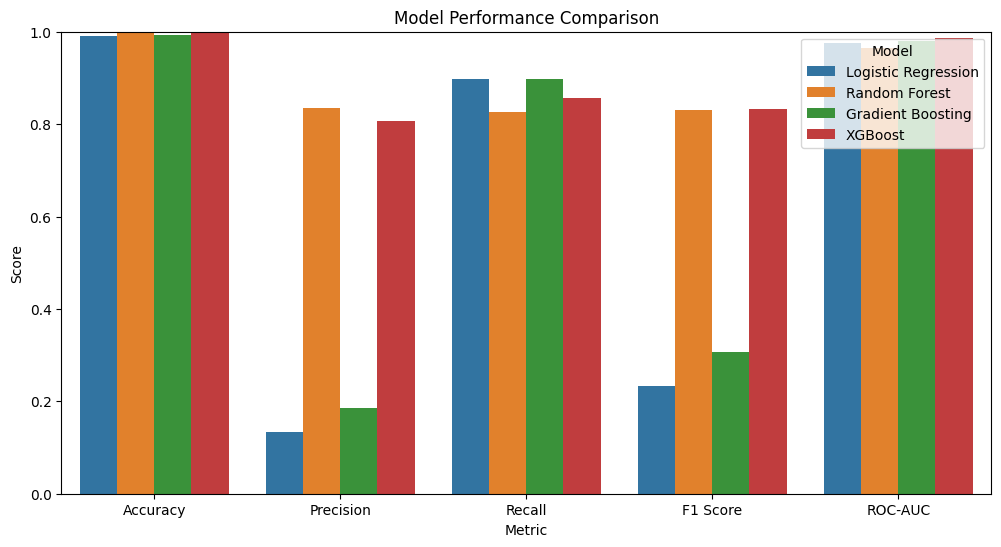

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming results_df is your model comparison DataFrame
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
results_melted = results_df.melt(id_vars='Model', value_vars=metrics, var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=results_melted, x='Metric', y='Score', hue='Model')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.show()


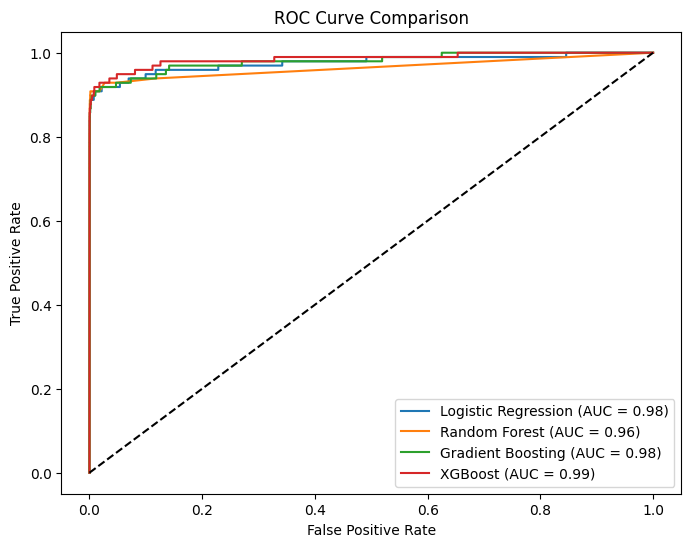

In [5]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

for name, model in models.items():
    y_proba = model.predict_proba(Xc_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(yc_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
